In [21]:
from glob import glob
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import tifffile as tiff
import pandas as pd
import cv2
import torch.nn as nn
import albumentations as A
import numpy as np
import time
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import tqdm
import math

In [22]:
"""
Global parameters for the UNet model defined here for easy access across files.
"""
# Copied from COMP3710 report

# Hyperparameters
LEARNING_RATE = 1e-4
NUM_EPOCHS = 30
BATCH_SIZE = 4
NUM_WORKERS = 4
PIN_MEMORY = True
PREDICTION_THRESHOLD = 0.8
# PREDICTION_THRESHOLD = 0.999

IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

HIGH_PASS_ALPHA = 0.1
HIGH_PASS_STRENGTH = 0.1

DATA_SUBSECTION = (960, 1080)

import os
print(os.getcwd())

test_dir = '/kaggle/input/blood-vessel-segmentation/test'
IS_LOCAL = not os.path.exists(test_dir)
IS_SUBMISSION = (not IS_LOCAL) and len(glob(test_dir+"/kidney_5/images/*.tif"))!=3

if IS_LOCAL:
    CHECKPOINT_DIR = '../../checkpoints/checkpoint.pth.tar'
else:
    CHECKPOINT_DIR = '/kaggle/input/checkpoint/checkpoints/checkpoint.pth.tar'

if not IS_SUBMISSION:
    VAL_DATASET_DIR = '../../data/train/kidney_2'

# base_path = 'data/train'
# base_path = 'data_downsampled512/train'
# dataset = 'kidney_1_dense'
# datasets = ['kidney_1_dense', 'kidney_1_voi', 'kidney_2', 'kidney_3_sparse']

e:\Documents2\rendom_prijects\VasculatureSegmentation\3DImprovedUNet\model


In [23]:
"""
Code copied from https://www.kaggle.com/code/aniketkolte04/sennet-hoa-seg-pytorch-attention-gated-unet
pytorch dataset for the challenge.
"""
class UsageDataset(Dataset):
    def __init__(self, image_files, 
                 input_size=(IMAGE_WIDTH, IMAGE_HEIGHT), 
                 augmentation_transforms=None):
        self.image_files = image_files
        self.input_size = input_size
        self.augmentation_transforms = augmentation_transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
       
        image_path = self.image_files[idx]

        image = preprocess_image(image_path)#, return_size=True)
        # orig_size = image.shape

        if self.augmentation_transforms:
            image = self.augmentation_transforms(image)

        return image#, torch.tensor(np.array([orig_size[2], orig_size[3]]))


def preprocess_image(path, return_size=False):
    
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    # img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # print(f'fresh process image img.shape: {img.shape}')
    img = np.tile(img[...,None],[1, 1, 3]) 
    img = img.astype('float32') 

    # scaling to 0-1
    mx = np.max(img)
    if mx:
        img/=mx
    
    orig_size = img.shape
    
    # print(f'process image img.shape: {img.shape}')
    img = np.transpose(img, (2, 0, 1))
    img_ten = torch.tensor(img)
    if return_size:
        return img_ten, orig_size
    else:
        return img_ten


def preprocess_mask(path):
    
    msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    msk = msk.astype('float32')
    msk/=255.0
    msk_ten = torch.tensor(msk)
    
    return msk_ten

def test_transform(image):
    
    image_np = image.permute(1, 2, 0).numpy()

    transform = A.Compose([
        # A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH, interpolation=cv2.INTER_NEAREST),
        A.Emboss(alpha=HIGH_PASS_ALPHA, strength=HIGH_PASS_STRENGTH, always_apply=True),  # High pass filter
    ])

    augmented = transform(image=image_np)
    augmented_image = augmented['image']

    augmented_image = torch.tensor(augmented_image, dtype=torch.float32).permute(2, 0, 1)

    return augmented_image

# def create_loader(image_files, mask_files, batch_size, 
#                   augmentations=None, shuffle=False):
    
#     dataset = CustomDataset(image_files, mask_files, augmentation_transforms=augmentations)
#     return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def create_test_loader(image_files, batch_size, 
                  augmentations=None, shuffle=False):
    
    dataset = UsageDataset(image_files, augmentation_transforms=augmentations)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch_idx: 12, data.shape: torch.Size([1, 3, 1041, 1511])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch_idx: 35, data.shape: torch.Size([1, 3, 1041, 1511])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch_idx: 60, data.shape: torch.Size([1, 3, 1041, 1511])
batch_idx: 62, data.shape: torch.Size([1, 3, 1041, 1511])


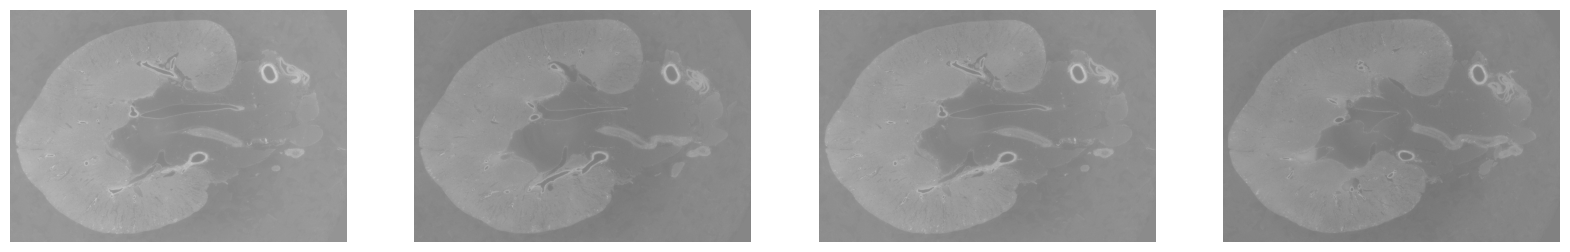

In [24]:
image_files = glob(os.path.join(VAL_DATASET_DIR, 'images/*.tif'))
mask_files = glob(os.path.join(VAL_DATASET_DIR, 'labels/*.tif'))
image_files = image_files[950:1050]
mask_files = mask_files[950:1050]
test_loader = create_test_loader(image_files, 1, augmentations=test_transform)

num_examples = 4
indices = np.random.choice(len(test_loader.dataset), num_examples, replace=False)
max_idx = max(indices)

plt.figure(figsize=(20, 20))
for batch_idx, data in enumerate(test_loader):
    if batch_idx in indices:
        print(f'batch_idx: {batch_idx}, data.shape: {data.shape}')
        plt.subplot(1, num_examples, np.where(indices==batch_idx)[0][0]+1)
        plt.imshow(data[0].permute(1, 2, 0))
        plt.axis('off')
    
    if batch_idx == max_idx:
        break

plt.show()

In [25]:
# functions to take an image and resize it to 1024x1024 and then split it into 4 512x512 images
def to_1024(image):
    """
    Converts image to 1024x1024
    """
    image = image.permute(1, 2, 0).numpy()
    image = cv2.resize(image, (1024, 1024), interpolation=cv2.INTER_NEAREST)
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
    return image

def split(img):
    """
    Expects a 1024x1024 image and splits it into 4 512x512 images
    """
    img = img.permute(1, 2, 0).numpy()
    img1 = img[:512, :512, :]
    img2 = img[:512, 512:, :]
    img3 = img[512:, :512, :]
    img4 = img[512:, 512:, :]
    img1 = torch.tensor(img1, dtype=torch.float32).permute(2, 0, 1)
    img2 = torch.tensor(img2, dtype=torch.float32).permute(2, 0, 1)
    img3 = torch.tensor(img3, dtype=torch.float32).permute(2, 0, 1)
    img4 = torch.tensor(img4, dtype=torch.float32).permute(2, 0, 1)
    return img1, img2, img3, img4

def recombine(img1, img2, img3, img4):
    """
    Expects 4 512x512 images and recombines them into a 1024x1024 image
    """
    img1 = img1.permute(1, 2, 0).numpy()
    img2 = img2.permute(1, 2, 0).numpy()
    img3 = img3.permute(1, 2, 0).numpy()
    img4 = img4.permute(1, 2, 0).numpy()
    img = np.zeros((1024, 1024, 3))
    img[:512, :512, :] = img1
    img[:512, 512:, :] = img2
    img[512:, :512, :] = img3
    img[512:, 512:, :] = img4
    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
    return img

def recombine_with_batch_dim(img1, img2, img3, img4):
    """
    Expects 4 512x512 images with batch dimension, [b, c, h, w] and recombines them into a 1024x1024 image
    """
    img1 = img1.permute(0, 2, 3, 1).numpy()
    img2 = img2.permute(0, 2, 3, 1).numpy()
    img3 = img3.permute(0, 2, 3, 1).numpy()
    img4 = img4.permute(0, 2, 3, 1).numpy()
    img = np.zeros((img1.shape[0], 1024, 1024, 3))
    img[:, :512, :512, :] = img1
    img[:, :512, 512:, :] = img2
    img[:, 512:, :512, :] = img3
    img[:, 512:, 512:, :] = img4
    img = torch.tensor(img, dtype=torch.float32).permute(0, 3, 1, 2)
    return img

def to_1303x912(image):
    image = image.permute(1, 2, 0).numpy()
    image = cv2.resize(image, (912, 1303), interpolation=cv2.INTER_NEAREST)
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
    return image

# def batch_tiling_split(image_batch, tile_size, tiles_in_x=0, tiles_in_y=0, debug=False):
#     """
#     Splits a batch of images into tiles of size tile_size x tile_size
#     Assumes batch shape is [b, c, h, w]
#     Args:
#         image_batch: batch of images to split
#         tile_size: size of tiles to split into
#         tiles_in_x: number of tiles in x direction
#         tiles_in_y: number of tiles in y direction
#     Returns:
#         A list of tiles
#     """
#     if tiles_in_x == 0:
#         tiles_in_x = math.ceil(image_batch.shape[3]/tile_size)
#     if tiles_in_y == 0:
#         tiles_in_y = math.ceil(image_batch.shape[2]/tile_size)
    
#     # the tiles must overlap, there must be tiles_in_x * tiles_in_y tiles all of the same size
#     img_size = image_batch.shape[2:]
#     if debug:
#         print(f'img_size: {img_size}')
#         print(f'tiles in x: {tiles_in_x}, tiles in y: {tiles_in_y}')
#     # these are the x, y values of the top left corner of each tile
#     x_start_pixels = np.linspace(0, img_size[1]-tile_size//2, tiles_in_x, dtype=np.int)
#     y_start_pixels = np.linspace(0, img_size[0]-tile_size//2, tiles_in_y, dtype=np.int)
#     if debug:
#         print(f'x_start_pixels: {x_start_pixels}')
#         print(f'y_start_pixels: {y_start_pixels}')
    
#     # keep the batch on cuda
#     # use torch functions 
#     tiles = []
#     for x in x_start_pixels:
#         for y in y_start_pixels:
#             tiles.append(image_batch[:, :, y:y+tile_size, x:x+tile_size])
    
#     return tiles

def batch_tiling_split(image_batch, tile_size, tiles_in_x=0, tiles_in_y=0, debug=False):
    """
    Splits a batch of images into evenly spaced tiles of size tile_size x tile_size.
    Assumes batch shape is [b, c, h, w]
    Args:
        image_batch: batch of images to split
        tile_size: size of tiles to split into
        tiles_in_x: number of tiles in x direction
        tiles_in_y: number of tiles in y direction
    Returns:
        A list of tiles
    """
    b, c, h, w = image_batch.shape

    # Calculate number of tiles if not specified
    if tiles_in_x == 0:
        tiles_in_x = math.ceil(w / tile_size)
    if tiles_in_y == 0:
        tiles_in_y = math.ceil(h / tile_size)

    # Calculate stride to evenly space tiles
    stride_x = (w - tile_size) / (tiles_in_x - 1) if tiles_in_x > 1 else 0
    stride_y = (h - tile_size) / (tiles_in_y - 1) if tiles_in_y > 1 else 0

    if debug:
        print(f'Image Size: {h}x{w}, Tile Size: {tile_size}x{tile_size}')
        print(f'Tiles in x: {tiles_in_x}, Tiles in y: {tiles_in_y}')
        print(f'Stride in x: {stride_x}, Stride in y: {stride_y}')

    tiles = []
    for i in range(tiles_in_y):
        for j in range(tiles_in_x):
            # Calculate start coordinates for the tile
            start_x = int(j * stride_x)
            start_y = int(i * stride_y)
            tile = image_batch[:, :, start_y:start_y + tile_size, start_x:start_x + tile_size]
            tiles.append(tile)

    return tiles


def recombine_tiles(tiles, original_size, tile_size, tiles_in_x, tiles_in_y):
    """
    Recombines a list of tiled images into a single image batch, correctly handling edge tiles
    to avoid black borders and keeping pixel positions consistent with the original image.
    Args:
        tiles: list of tiled images
        original_size: tuple, size of the original image (height, width)
        tile_size: size of each tile (assuming square tiles)
        tiles_in_x: number of tiles in the x direction
        tiles_in_y: number of tiles in the y direction
    Returns:
        A single image batch of recombined tiles.
    """
    original_height, original_width = original_size
    b, c, _, _ = tiles[0].shape

    # Create tensors for the recombined image and the count for averaging
    recombined = torch.zeros((b, c, original_height, original_width), dtype=tiles[0].dtype, device=tiles[0].device)
    count_matrix = torch.zeros_like(recombined)

    tile_index = 0
    for i in range(tiles_in_y):
        for j in range(tiles_in_x):
            # Calculate start coordinates for the tile
            start_x = min(j * (original_width - tile_size) // (tiles_in_x - 1), original_width - tile_size)
            start_y = min(i * (original_height - tile_size) // (tiles_in_y - 1), original_height - tile_size)
            
            end_x = start_x + tile_size
            end_y = start_y + tile_size

            # Place tile and update count matrix
            recombined[:, :, start_y:end_y, start_x:end_x] += tiles[tile_index]
            count_matrix[:, :, start_y:end_y, start_x:end_x] += 1

            tile_index += 1

    # Average the overlapped regions
    recombined /= count_matrix

    return recombined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Size: 1041x1511, Tile Size: 512x512
Tiles in x: 3, Tiles in y: 3
Stride in x: 499.5, Stride in y: 264.5
len tiles: 9


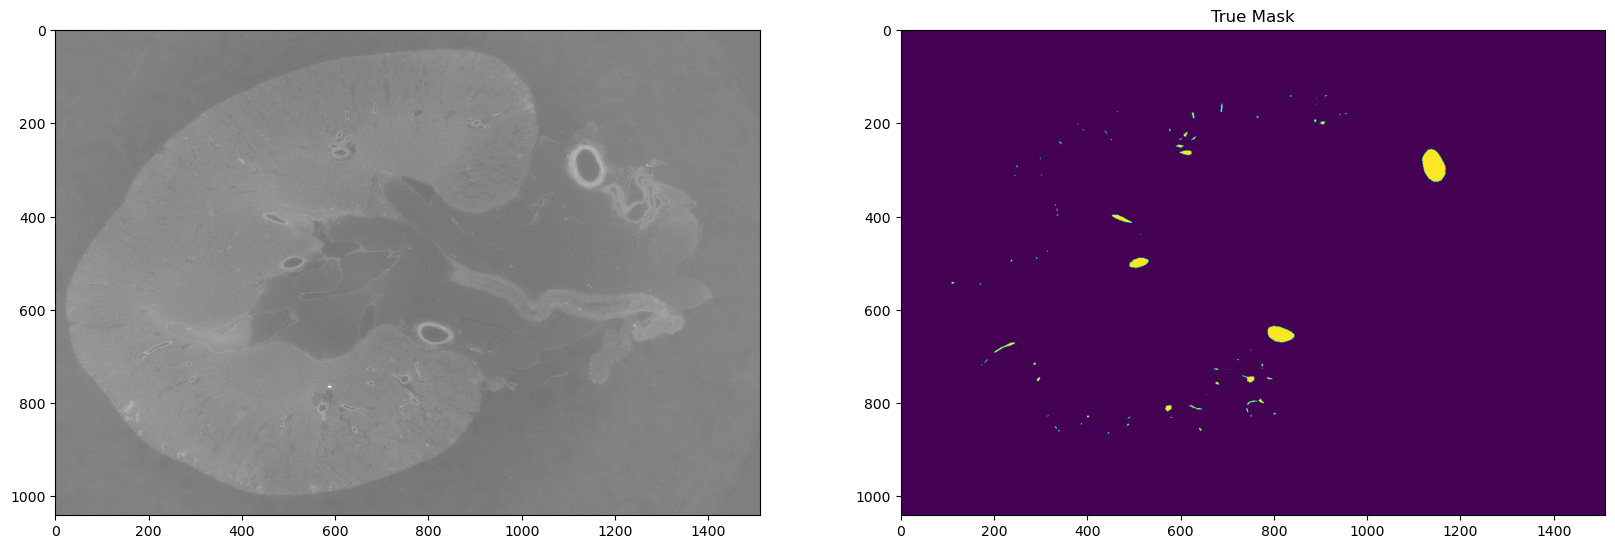

In [26]:
for batch_idx, data in enumerate(test_loader):
    # remove batch dimension
    img_batch = data
    mask = preprocess_mask(mask_files[batch_idx])
    break

# img1023 = to_1024(img)
# print(f'img.shape: {img.shape}')

# img1, img2, img3, img4 = split(img1023)

# recombined = recombine(img1, img2, img3, img4)
# orig_size = to_1303x912(recombined)

# # add batch dimension back in
# img1 = img1.unsqueeze(0)

# plt.figure(figsize=(20, 20))
# # plt.subplot(2, 2, 1)
# # plt.imshow(img1.permute(1, 2, 0))
# # plt.subplot(2, 2, 2)
# # plt.imshow(img2.permute(1, 2, 0))
# # plt.subplot(2, 2, 3)
# # plt.imshow(img3.permute(1, 2, 0))
# # plt.subplot(2, 2, 4)
# # plt.imshow(img4.permute(1, 2, 0))
# plt.imshow(orig_size.permute(1, 2, 0))
# plt.show()
tiles_in_x = 3
tiles_in_y = 3

tiles = batch_tiling_split(img_batch, 512, tiles_in_x=tiles_in_x, tiles_in_y=tiles_in_y, debug=True)
print(f'len tiles: {len(tiles)}')
orig_size = (1041, 1511)
reconstruction = recombine_tiles(tiles, orig_size, 512, tiles_in_x, tiles_in_y)

mask_tiles = batch_tiling_split(mask.unsqueeze(0).unsqueeze(0), 512, tiles_in_x=tiles_in_x, tiles_in_y=tiles_in_y)
mask = recombine_tiles(mask_tiles, orig_size, 512, tiles_in_x, tiles_in_y)
mask = mask.squeeze(0).squeeze(0)

plt.figure(figsize=(20, 20))

# for i, tile in enumerate(tiles):
#     tile = tile.squeeze(0).permute(1, 2, 0).numpy()
#     plt.subplot(4, 3, i+1)
#     plt.imshow(tile)
plt.subplot(1, 2, 1)
img = reconstruction.squeeze(0).permute(1, 2, 0).numpy()
# plt.subplot(4, 3, 10)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask.numpy())
plt.title('True Mask')
plt.show()